In [1]:
#import tflearn packages

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

import tensorflow as tf

from tflearn.data_utils import shuffle
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

#import other packages
import pandas as pd
import sklearn
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import measure
%matplotlib inline

from keras.utils import np_utils

import os
from os import getcwd
from os import listdir
from os.path import isfile, join, isdir

import skimage
from skimage import measure
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
#randomly choose a subset of training images to make it run faster

#import images

def get_paths(foldNames):
  
    paths = dict.fromkeys(foldNames)

    for idx,g in enumerate(foldNames):
        fileNames = [f for f in listdir(join(trainPath,g)) if isfile(join(trainPath,g, f))]
        for i,f in enumerate(fileNames):
            fileNames[i] = join(trainPath,g,f)     
        paths[g] = fileNames
        
    return paths

trainPath = '../data/raw/train'
testPath = '../data/raw/test_stg1'
fish_classes = [f for f in listdir(trainPath) if isdir(join(trainPath, f))]
groupData = pd.DataFrame ({'group': fish_classes})
fish_paths = get_paths(fish_classes)

keys_to_remove = [key for key, value in fish_paths.iteritems()
                  if '.DS_Store' in value]

for key in keys_to_remove:
    del fish_paths[key]
    
#for key, item in fish_paths:
#    if ".DS_Store" in item:
#       del fish_paths[key]
        
keys_to_remove        
#this I did to print the paths to make sure I understand the dictionary
#n = 1
#for k,v in fish_paths.items():
#    if '.DS_Store' in v:
#        print(k, v)
#    if n == 1:
#        print(v)
#        n = 2

[]

In [3]:
#label images by directory

for idx,fish in enumerate(fish_classes):
    groupData.ix[idx,'num files'] = int(len(fish_paths[fish]))
    
files = []
Y_cat = []

for fish in fish_classes:
    fish_files = fish_paths[fish]
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    Y_cat.extend(y_fish)


is_to_remove = [i for i in range(0,len(files))
                  if '.DS_Store' in files[i]]

print(is_to_remove)

for i in is_to_remove:
    del files[i]
    del Y_cat[i]
        
Y_cat = np.array(Y_cat) 



[0]


In [4]:
#downsample images
def read_image(src):
    """Read and resize individual images"""
    im = io.imread(src)
    im = resize(im, (ROWS, COLS))
    return im

ROWS = 90  #90 720
COLS = 160 #160 1280
CHANNELS = 3

X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)

Processed 0 of 3777
Processed 1000 of 3777
Processed 2000 of 3777
Processed 3000 of 3777


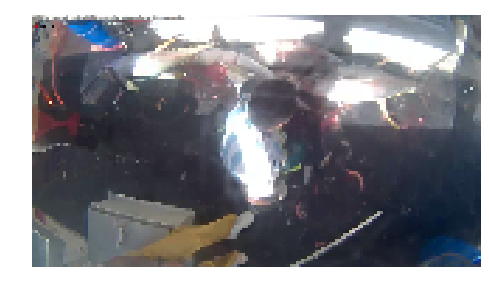

In [5]:
for i, f in enumerate(files): 
    im = read_image(f)
    X_all[i] = im
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

##view example image
image = X_all[0]
plt.figure(figsize=(5, 5))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
#split into train and test for cross-validation
# One Hot Encoding Labels
#    Transform the categorical array Y_all into matrix of the same height, 
#    but with a boolean column for each category.
Y_all = LabelEncoder().fit_transform(Y_cat)
Y_all = np_utils.to_categorical(Y_all)

# test_size: between 0 and 1. proportion of the dataset to include in the test split
# random_state: Pseudo-random number generator state used for random sampling. How to shoose this?
# stratify: this is ensuring that the split datasets are balanced, i.e. contains the same 
# percentage of classes

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=Y_all)

In [7]:
#build a simple CNN

def dnn_test1():
    #needed to run this tensorflow operation in order to build the network and subsequently 
    #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
    #errors. Could also get around this issue by restarting kernel, but that's annoying.
    with tf.Graph().as_default():
        
        #input layer with shape of data specified. In this case, dimensions of our images, 
        #rows X cols X rgb array. The initial 'None' is for an unknown dimension reflecting the 
        #"number of samples that are processed in a batch"
        
        # Building convolutional network

        net = input_data(shape=[None, ROWS, COLS, 3])
        net = conv_2d(net, 32, 3, activation='relu', regularizer="L2")
        net = max_pool_2d(net, 2)
        net = local_response_normalization(net)
        net = conv_2d(net, 64, 3, activation='relu', regularizer="L2")
        net = max_pool_2d(net, 2)
        net = local_response_normalization(net)
        net = fully_connected(net, 72, activation='relu')
        net = fully_connected(net, 8, activation='softmax')
        net = regression(net)
        return tflearn.DNN(net)

In [8]:
#test on subset of training images you didn't use; if it works well could do a full train:test and submit
# Define model
model = dnn_test1()

# Start training (apply gradient descent algorithm). Will want to specify multiple epochs 
# typically unless just testing
model.fit(X_train, Y_train, n_epoch=10,
          show_metric=True, batch_size=16, validation_set = (X_valid, Y_valid))

#started running at 12:22 PM 

#model predict

Training Step: 1889  | total loss: 0.02090 | time: 110.684s
| Adam | epoch: 010 | loss: 0.02090 - acc: 0.9957 -- iter: 3008/3021
Training Step: 1890  | total loss: 0.01888 | time: 120.798s
| Adam | epoch: 010 | loss: 0.01888 - acc: 0.9961 | val_loss: 0.23799 - val_acc: 0.9458 -- iter: 3021/3021
--


In [8]:
def dnn_test2():
    #needed to run this tensorflow operation in order to build the network and subsequently 
    #create the model, multiple times. Rebuilding without resetting the tf.Graph object produces
    #errors. Could also get around this issue by restarting kernel, but that's annoying.
    with tf.Graph().as_default():
        
        #input layer with shape of data specified. In this case, dimensions of our images, 
        #rows X cols X rgb array. The initial 'None' is for an unknown dimension reflecting the 
        #"number of samples that are processed in a batch"
        
        # Building convolutional network

        network = input_data(shape=[None, ROWS, COLS, 3])
        network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
        network = max_pool_2d(network, 2)
        network = local_response_normalization(network)
        network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
        network = max_pool_2d(network, 2)
        network = local_response_normalization(network)
        network = fully_connected(network, 128, activation='tanh')
        network = dropout(network, 0.8)
        network = fully_connected(network, 256, activation='tanh')
        network = dropout(network, 0.8)
        network = fully_connected(network, 8, activation='softmax')
        network = regression(network, optimizer='adam', learning_rate=0.01,
                loss='categorical_crossentropy', name='target')
        return tflearn.DNN(network)

In [9]:
# read in test photo set
test_files = [im for im in os.listdir(testPath)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)
for i, im in enumerate(test_files): 
    test[i] = read_image(join(testPath,im))

    

In [10]:
#model predict

test_preds1 = model.predict(test)

submission = pd.DataFrame(test_preds1, columns=fish_classes)
submission.insert(0, 'image', test_files)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.000031,0.000001,9.354110e-06,2.424570e-06,0.999876,0.000077,3.615401e-06,0.000001
1,img_00007.jpg,0.780536,0.055396,9.879785e-06,4.948371e-02,0.000030,0.103886,1.111986e-07,0.010659
2,img_00009.jpg,0.991227,0.000073,2.366462e-06,2.067438e-06,0.008317,0.000360,1.740540e-05,0.000001
3,img_00018.jpg,0.999169,0.000003,2.164374e-07,7.743190e-08,0.000000,0.000002,6.335633e-11,0.000826
4,img_00027.jpg,0.993407,0.000001,3.311636e-08,9.881232e-08,0.000005,0.003091,8.242127e-07,0.003495


In [11]:
submission.to_csv('../data/processed/tflearn/submission_170219.csv')

In [15]:
#test on subset of training images you didn't use; if it works well could do a full train:test and submit
# Define model
model2 = dnn_test2()

# Start training (apply gradient descent algorithm). Will want to specify multiple epochs 
# typically unless just testing
model2.fit(X_train, Y_train, n_epoch=10,
          show_metric=True, batch_size=16)

#model predict

test_preds2 = model2.predict(test)

Training Step: 188  | total loss: 1.75847 | time: 147.236s
| Adam | epoch: 001 | loss: 1.75847 - acc: 0.3769 -- iter: 3008/3021
Training Step: 189  | total loss: 1.69012 | time: 147.937s
| Adam | epoch: 001 | loss: 1.69012 - acc: 0.3954 -- iter: 3021/3021
--


In [16]:
submission2 = pd.DataFrame(test_preds2, columns=fish_classes)
submission2.insert(0, 'image', test_files)
submission2.head()
submission2.to_csv('../data/processed/tflearn/submission_170218_7.csv')

In [17]:
submission2.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.091461,0.041506,0.028659,0.000908,0.123104,0.208644,0.001035,0.504683
1,img_00007.jpg,0.541459,0.052419,0.000953,0.000832,0.098846,0.150791,0.000143,0.154558
2,img_00009.jpg,0.542919,0.054159,0.000893,0.000935,0.123039,0.143450,0.000173,0.134432
3,img_00018.jpg,0.564140,0.046599,0.000851,0.000693,0.092821,0.136568,0.000134,0.158193
4,img_00027.jpg,0.088694,0.034055,0.022211,0.000557,0.082027,0.155033,0.000866,0.616557


In [ ]:
###hmm, it looks like the two NNs are outputting the exact same thing? is this working?